In [1]:
!git clone https://github.com/sthalles/SimCLR.git
%cd SimCLR

Cloning into 'SimCLR'...
remote: Enumerating objects: 571, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 571 (delta 108), reused 106 (delta 106), pack-reused 349 (from 1)
Receiving objects: 100% (571/571), 82.46 MiB | 13.18 MiB/s, done.
Resolving deltas: 100% (312/312), done.
/content/SimCLR


In [2]:
!pip install torch torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
%cd /content/SimCLR

/content/SimCLR


In [13]:
!python run.py \
  -dataset-name cifar10 \
  -data ./data \
  --batch-size 256 \
  --epochs 20 \
  --temperature 0.5 \
  --n-views 2 \
  --log-every-n-steps 10

2025-05-12 06:07:59.713618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747030080.035887    6628 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747030080.124304    6628 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 06:08:00.832266: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 

In [6]:
from google.colab import files
files.download('/content/SimCLR/runs/May12_03-21-08_63e6cf6917bf/checkpoint_0010.pth.tar')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from models.resnet_simclr import ResNetSimCLR

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Загружаем модель
model = ResNetSimCLR(base_model='resnet18', out_dim=128)
checkpoint = torch.load('/content/SimCLR/runs/May12_06-08-09_e6e809783326/checkpoint_0020.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval().to(device)

# CIFAR-10
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])
dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=512, shuffle=False)

# Эмбеддинги
embeddings, labels, original_images = [], [], []

with torch.no_grad():
    for images, targets in loader:
        images = images.to(device)
        h = model.backbone(images)  # <-- получаем эмбеддинги без головы
        embeddings.append(h.cpu())
        labels.append(targets)
        original_images.append(images.cpu())

embeddings = torch.cat(embeddings)
labels = torch.cat(labels)
original_images = torch.cat(original_images)

torch.save({
    'embeddings': embeddings,
    'labels': labels,
    'original_images': original_images,
}, 'cifar10_simclr_features.pt')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
import numpy as np
from scipy.stats import pearsonr

def correlation_dissimilarity(emb1, emb2):
    """
    emb1 (np.array) : embedding in one feature space
    emb2 (np.array) : embedding in another feature space
    """
    dissim1 = 1. - np.corrcoef(emb1)
    dissim2 = 1. - np.corrcoef(emb2)

    triu_indices = np.triu_indices_from(dissim1, k=1)
    flat1 = dissim1[triu_indices]
    flat2 = dissim2[triu_indices]

    # Compute second-order similarity (Pearson correlation)
    r, _ = pearsonr(flat1, flat2)
    return r


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def train_linear_classifier(X, y, test_size=0.2, random_state=42, **kwargs):
    """
    Trains a linear classifier (Logistic Regression) and returns the model and accuracy.

    Parameters:
    X (array-like): Feature matrix
    y (array-like): Target vector
    test_size (float): Proportion of data to use for testing (default: 0.2)
    random_state (int): Random seed for reproducibility (default: 42)
    **kwargs: Additional arguments to pass to LogisticRegression

    Returns:
    tuple: (trained_model, accuracy_score)
    """
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Initialize and train the linear classifier
    model = LogisticRegression(**kwargs)
    model.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return model, accuracy

def encode_set(encoder_function: callable, loader, original_loader, device="cpu"):
    all_embeddings = []
    all_labels = []
    all_original_images = []

    with torch.no_grad():
        for (images_dino, targets), (images_orig, _) in zip(loader, original_loader):
            images_dino = images_dino.to(device, non_blocking=True)
            embeddings = encoder_function(images_dino).cpu()
            all_embeddings.append(embeddings)
            all_labels.append(targets)
            all_original_images.append(images_orig)

    embeddings = torch.cat(all_embeddings)  # [N, D]
    labels = torch.cat(all_labels)
    original_images = torch.cat(all_original_images)
    original_images = original_images.reshape(original_images.shape[0], -1)

    return (embeddings.numpy(),
            labels.numpy(),
            original_images.numpy())


def run(encoder_function: callable, loader: torch.utils.data.DataLoader, original_loader: torch.utils.data.DataLoader,
        logger = None, device = "cpu"):
    embeddings_np, labels_np, original_images_np = encode_set(encoder_function, loader, original_loader, device)
    if not logger is None:
        logger.log({
            "classification_accuracy" : train_linear_classifier(embeddings_np, labels_np)[1],
            "second_order_similarity" : correlation_dissimilarity(embeddings_np, original_images_np)
        })
    print(f"classification_accuracy {train_linear_classifier(embeddings_np, labels_np)[1]},\nsecond_order_similarity {correlation_dissimilarity(embeddings_np, original_images_np)}")
    return embeddings_np, labels_np, original_images_np

In [16]:
run(model.backbone, loader, loader, device=device)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


classification_accuracy 0.469,
second_order_similarity 0.47538791568226096


(array([[ 1.939364  , -1.3926342 , -0.43160707, ...,  0.03054565,
         -0.5591707 , -3.2019136 ],
        [-2.271316  ,  1.5654727 , -3.2129097 , ...,  1.9501206 ,
         -0.7821483 ,  0.79437023],
        [-0.37382945,  2.3519976 , -3.7740533 , ...,  4.3608427 ,
         -0.20288903,  1.1052263 ],
        ...,
        [ 3.0858681 , -4.2642674 , -4.9871297 , ...,  4.2603803 ,
         -1.8060874 , -0.7463966 ],
        [ 4.9266167 ,  0.64291537, -0.158313  , ...,  2.487252  ,
         -1.9406059 , -2.2329683 ],
        [-1.6613368 ,  3.2255166 ,  1.7638091 , ...,  0.22223797,
          2.3086798 ,  0.5566736 ]], dtype=float32),
 array([3, 8, 8, ..., 5, 1, 7]),
 array([[0.61960787, 0.62352943, 0.64705884, ..., 0.4862745 , 0.5058824 ,
         0.43137255],
        [0.92156863, 0.90588236, 0.9098039 , ..., 0.69803923, 0.7490196 ,
         0.78039217],
        [0.61960787, 0.61960787, 0.54509807, ..., 0.03137255, 0.01176471,
         0.02745098],
        ...,
        [0.07843138, 0.0

In [4]:
!ls -lh /content/checkpoint_0010.pth.tar

-rw-r--r-- 1 root root 132M May 12 05:49 /content/checkpoint_0010.pth.tar


In [6]:
checkpoint = torch.load('/content/checkpoint_0010.pth.tar', map_location='cpu')
print(checkpoint.keys())

dict_keys(['epoch', 'arch', 'state_dict', 'optimizer'])


In [8]:
from google.colab import files
files.download('/content/SimCLR/cifar10_simclr_features.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


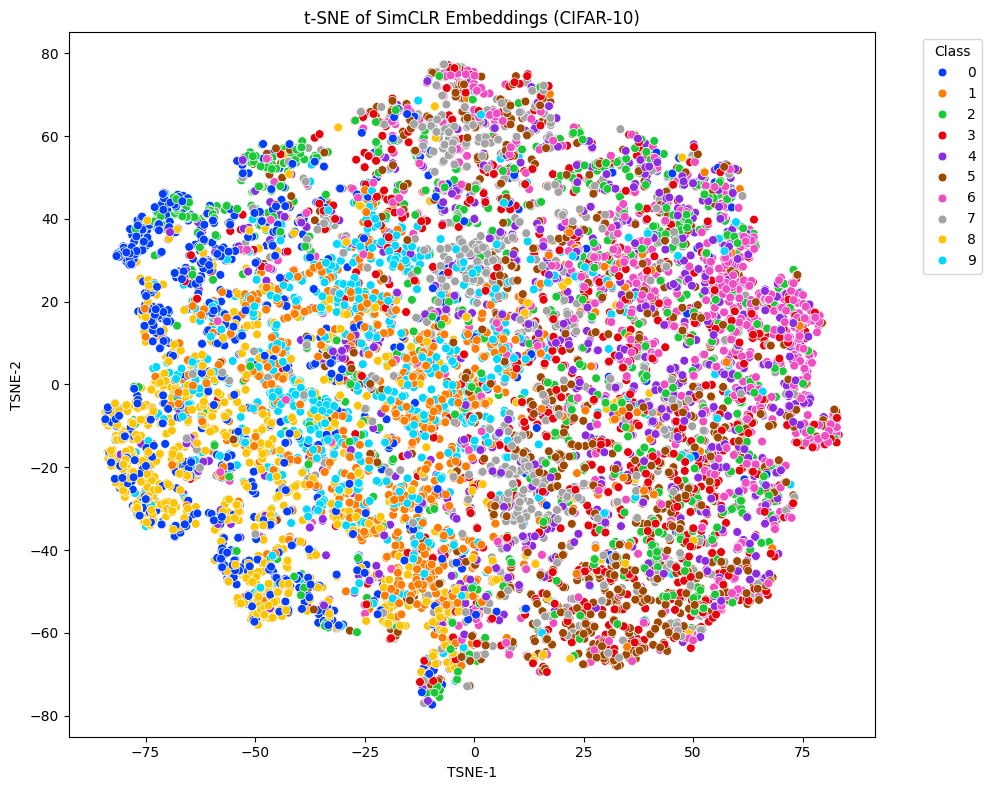

In [9]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
data = torch.load('/content/SimCLR/cifar10_simclr_features.pt', weights_only=False)
embeddings = data['embeddings']
labels = data['labels']

# Перевод в numpy
embeddings_np = embeddings.detach().cpu().numpy()
labels_np = labels.detach().cpu().numpy()

# Применим t-SNE (занимает 1–2 минуты на CPU)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Визуализация
plt.figure(figsize=(10, 8))
palette = sns.color_palette("bright", 10)
sns.scatterplot(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    hue=labels_np,
    palette=palette,
    legend='full',
    s=40
)
plt.title("t-SNE of SimCLR Embeddings (CIFAR-10)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, ColorBar
from bokeh.transform import linear_cmap, factor_cmap
from bokeh.palettes import Viridis256
from bokeh.layouts import row

import plotly.express as px

def embedding_plotter(embedding, data=None, hue=None, hover=None, tools = None, nv_cat = 5, height = 400, width = 400, display_result=True):
    '''
    Рисовалка эмбеддинга. 2D renderer: bokeh. 3D renderer: plotly.
    Обязательные инструменты:
        - pan (двигать график)
        - box zoom
        - reset (вылезти из зума в начальное положение)

        embedding: something 2D/3D, slicable ~ embedding[:, 0] - валидно
            Эмбеддинг
        data: pd.DataFrame
            Данные, по которым был построен эмбеддинг
        hue: string
            Колонка из data, по которой красим точки. Поддерживает интерактивную легенду: по клику на каждое
                значение hue можно скрыть весь цвет.
        hover: string or list of strings
            Колонк[а/и] из data, значения которых нужно выводить при наведении мышки на точку
        nv_cat: int
            number of unique values to consider column categorical
        tools: iterable or string in form "tool1,tool2,..." or ["tool1", "tool2", ...]
            tools for the interactive plot
        height, width: int
            parameters of the figure
        display_result: boolean
            if the results are displayed or just returned

    '''
    if tools is None:
        tools = 'lasso_select,box_select,pan,zoom_in,zoom_out,reset,hover'
    else:
        if hover and not("hover" in tools):
            tools = 'hover,'+",".join(tools)


    if embedding.shape[1] == 3:
        if hover:
            hover_data = {h:True for h in hover}
        else:
            hover_data = None
        df = pd.DataFrame(embedding, columns = ['x', 'y', 'z'])
        df = pd.concat((df, data), axis=1)
        fig = px.scatter_3d(
            data_frame = df,
            x='x',
            y='y',
            z='z',
            color=df[hue],
            hover_data = hover_data
        )

        fig.update_layout(
            modebar_add=tools.split(","),
        )

        fig.update_traces(marker_size=1, selector=dict(type='scatter3d'))

        if display_result: fig.show()

    if embedding.shape[1] == 2:
        output_notebook()
        df = pd.DataFrame(embedding, columns = ['x', 'y'])
        df = pd.concat((df, data), axis=1)
        tooltips = [
            ('x, y', 'y'),
            ('index', '$index')
        ]
        if hover:
            for col in hover:
                tooltips.append((col, "@"+col))
        fig = figure(tools=tools, width=width, height=height, tooltips=tooltips)
        if df[hue].nunique() < nv_cat or df[hue].dtype == "category":
            df[hue] = df[hue].astype(str)
            source = ColumnDataSource(df)
            color_mapper = factor_cmap(
            field_name=hue,
            palette='Category10_3',
            factors=df[hue].unique()
            )
            fig.scatter(
            x='x', y='y',
            color=color_mapper,
            source=source,
            legend_group=hue)

            fig.legend.location = 'bottom_left'
            fig.legend.click_policy = 'mute'
        else:
            source = ColumnDataSource(df)
            color_mapper = linear_cmap(
                field_name=hue,
                palette=Viridis256,
                low=min(df[hue]),
                high=max(df[hue]))
            fig.scatter(
                x='x', y='y',
                color=color_mapper,
                source=source)
            color_bar = ColorBar(color_mapper=color_mapper['transform'], width=8, location=(0,0), title = hue)
            fig.add_layout(color_bar, 'right')


        if display_result: show(fig)

    if embedding.shape[1] > 3:
        print("wrong species, doooooodes")
    else: return fig

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

# Загрузка данных
data = torch.load('/content/SimCLR/cifar10_simclr_features.pt', weights_only=False)
embeddings = data['embeddings']
labels = data['labels']

# Перевод в numpy
embeddings_np = embeddings.detach().cpu().numpy()
labels_np = labels.detach().cpu().numpy()

# Assuming your embeddings are in a variable called 'embeddings'
# embeddings = np.random.rand(10000, 384)  # Example - replace with your actual embeddings

# Create t-SNE
tsne = TSNE(n_components=2, random_state=1,
            init='pca', n_iter=5000,
            metric='cosine')

# Fit and transform your data
tsne_results = tsne.fit_transform(embeddings_np[:1000])

# Prepare the data DataFrame correctly
data_df = pd.DataFrame({
    'label': np.array(labels_np[:1000])  # Assuming you have labels
    # Add any other columns you want for hover information
})

# Call the plotting function correctly
embedding_plotter(
    embedding=tsne_results,  # This should be your 2D t-SNE results (1000x2 array)
    data=data_df,            # This contains your labels and other metadata
    hue='label',             # Column name in data_df to use for coloring
)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


figure(id='p1001', ...)